### 데이터 불러오기 및 기초 정보 확인

- `secom.data`: 1567개 샘플, 590개 센서 측정값
- `secom.labels`: 각 샘플의 라벨 정보 (`-1`: 양품, `1`: 불량)

두 파일을 pandas로 읽어온 후, 라벨을 feature와 병합하고 기본적인 정보(크기, 결측치 등)를 확인한다.


In [2]:
import pandas as pd
import numpy as np

# 데이터 경로 설정 (파일이 같은 폴더에 있다고 가정)
data_path = "secom.data"
label_path = "secom_labels.data"

# 데이터 불러오기 (공백으로 구분된 파일)
X = pd.read_csv(data_path, sep='\\s+', header=None)
y = pd.read_csv(label_path, sep='\\s+', header=None)

# 라벨 컬럼 이름 지정
y.columns = ['label', 'timestamp']
y = y.drop(columns='timestamp')  # timestamp는 사용하지 않음

# 라벨을 feature에 추가
df = pd.concat([X, y], axis=1)
df.columns = [f'feature_{i}' for i in range(X.shape[1])] + ['label']

# 확인
print("데이터 shape:", df.shape)
print("양품/불량 분포:\n", df['label'].value_counts())
df.head()


데이터 shape: (1567, 591)
양품/불량 분포:
 label
-1    1463
 1     104
Name: count, dtype: int64


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


### 데이터 분할 (Train/Validation/Test)
전체 데이터를 6:2:2 비율로 나눈다.

클래스 불균형을 반영해 stratified split을 사용한다.

결측치 상태 그대로 나누고, 전처리는 Train 기준으로 진행한다.


In [3]:
from sklearn.model_selection import train_test_split

# Feature와 Label 분리
X = df.drop(columns=['label'])
y = df['label']

# 1차 분할: Train 60%, Temp 40% (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 2차 분할: Validation 20%, Test 20% (Temp을 반으로 나눔)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 확인
print(" Train shape:", X_train.shape, y_train.shape)
print(" Validation shape:", X_val.shape, y_val.shape)
print(" Test shape:", X_test.shape, y_test.shape)

# 클래스 분포 확인
print("\nClass Distribution:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Validation:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))


 Train shape: (940, 590) (940,)
 Validation shape: (313, 590) (313,)
 Test shape: (314, 590) (314,)

Class Distribution:
Train:
 label
-1    0.934043
 1    0.065957
Name: proportion, dtype: float64
Validation:
 label
-1    0.932907
 1    0.067093
Name: proportion, dtype: float64
Test:
 label
-1    0.933121
 1    0.066879
Name: proportion, dtype: float64


###  EDA (Exploratory Data Analysis)
- Train 데이터 기준으로만 EDA 수행
- 주요 이상치, 변수 간 중복 여부 탐색
- 클래스 불균형 확인 및 처리 필요 여부 판단


총 결측치가 있는 변수 개수: 446


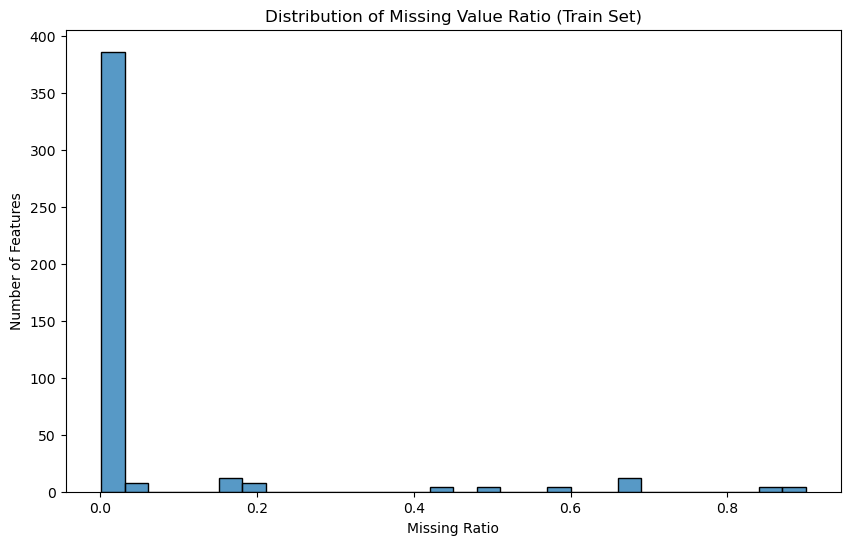

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 결측치 개수 및 비율 확인
missing_counts = X_train.isnull().sum()
missing_ratio = missing_counts / len(X_train)

# 결측치가 있는 변수만 시각화
missing_df = pd.DataFrame({'missing_count': missing_counts, 'missing_ratio': missing_ratio})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_ratio', ascending=False)

print(f"총 결측치가 있는 변수 개수: {missing_df.shape[0]}")

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(missing_df['missing_ratio'], bins=30, kde=False)
plt.title("Distribution of Missing Value Ratio (Train Set)")
plt.xlabel("Missing Ratio")
plt.ylabel("Number of Features")
plt.show()


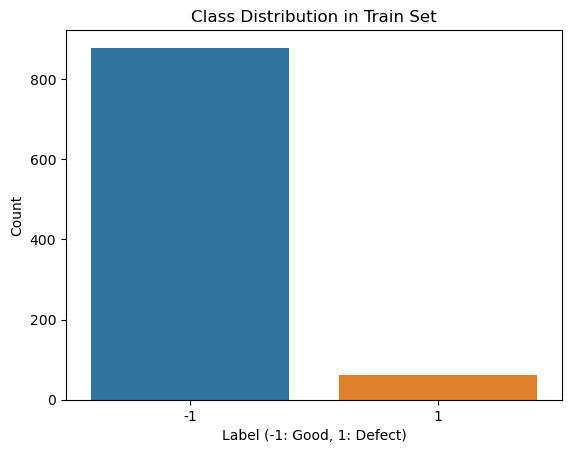

In [7]:
# 클래스 비율 시각화
sns.countplot(x=y_train)
plt.title("Class Distribution in Train Set")
plt.xlabel("Label (-1: Good, 1: Defect)")
plt.ylabel("Count")
plt.show()


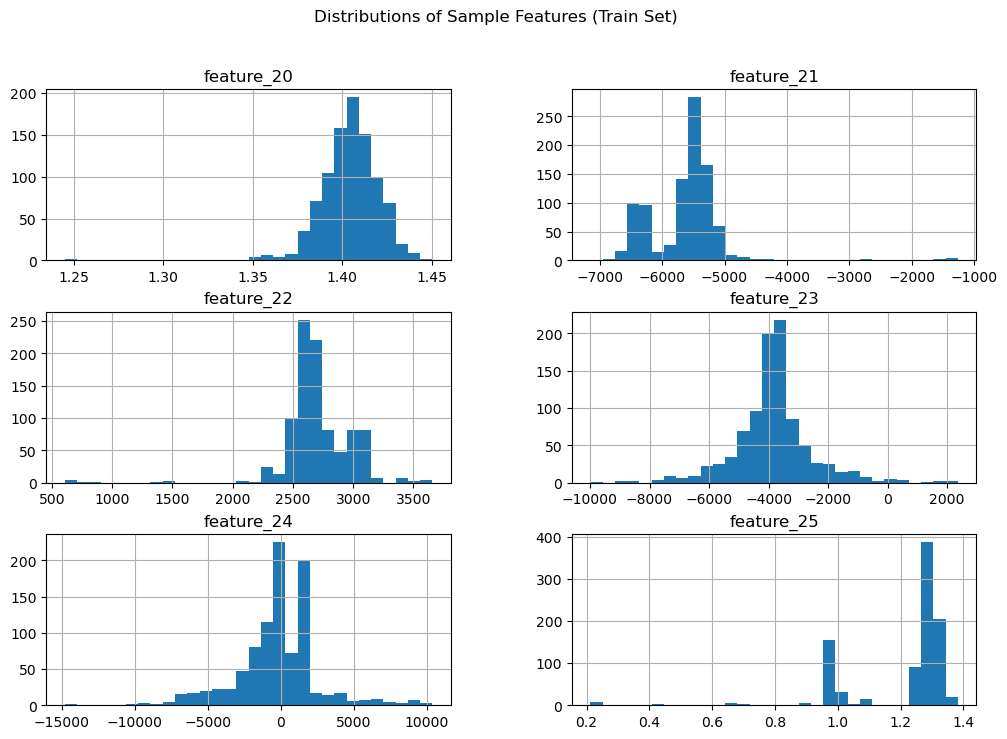

In [10]:
# 수치형 변수 중 결측치가 없는 컬럼만 추출
no_missing_cols = X_train.columns[X_train.isnull().sum() == 0]
numeric_cols = X_train[no_missing_cols].select_dtypes(include=[np.number]).columns.tolist()

# 그 중 일부 샘플만 선택하여 시각화
sample_cols = numeric_cols[:6]

# 히스토그램 시각화
X_train[sample_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Distributions of Sample Features (Train Set)")
plt.show()


### 변수별 Target(y)과의 관계 시각화
- 각 feature와 target(`y`) 간의 상관관계를 분석
- `상관계수 절댓값` 기준 상위 10개 변수 선택
- 선택된 변수들에 대해 클래스별 분포를 시각화하여 `양품 vs 불량` 간의 차이 탐색


In [12]:
# 1. label을 포함한 데이터셋 생성 (결측치 있는 변수 제외)
X_corr_valid = X_train.copy()
X_corr_valid['label'] = y_train.values

# 2. 피어슨 상관계수 계산
correlations = X_corr_valid.corr()['label'].drop('label')

# 3. 절댓값 기준으로 상위 10개 변수 선택
top_corr_features = correlations.abs().sort_values(ascending=False).head(10).index.tolist()

print("📌 y와 상관관계 절댓값이 가장 높은 변수 10개:")
print(top_corr_features)


📌 y와 상관관계 절댓값이 가장 높은 변수 10개:
['feature_293', 'feature_103', 'feature_158', 'feature_59', 'feature_64', 'feature_510', 'feature_21', 'feature_431', 'feature_430', 'feature_434']


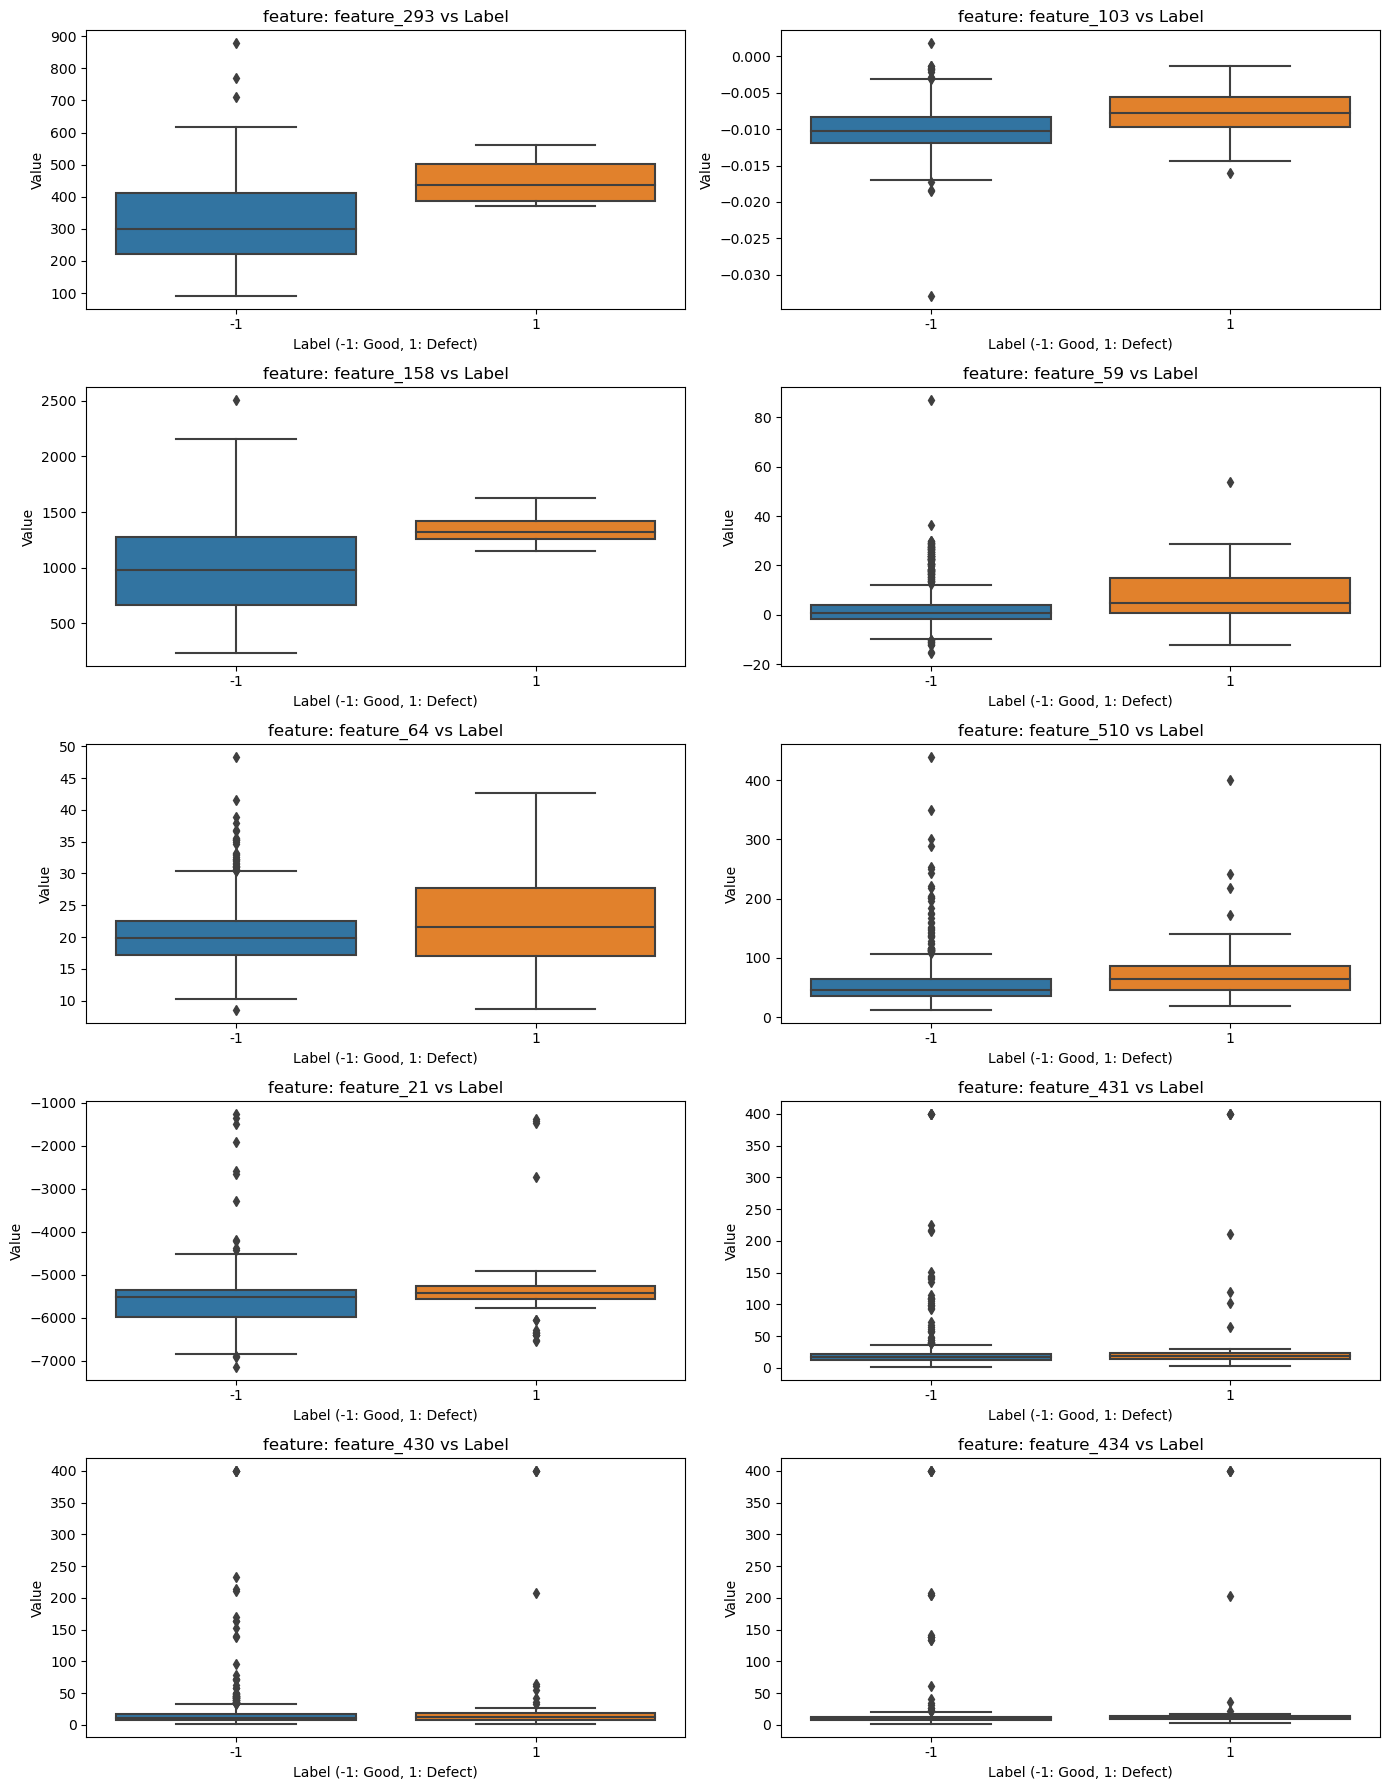

In [16]:
# 4. 박스플롯으로 양품/불량 간 변수 분포 시각화
plt.figure(figsize=(14, 18))
for i, col in enumerate(top_corr_features):
    plt.subplot(5, 2, i+1)
    sns.boxplot(x=y_train, y=X_train[col])
    plt.title(f"feature: {col} vs Label")
    plt.xlabel("Label (-1: Good, 1: Defect)")
    plt.ylabel("Value")

plt.tight_layout()
plt.show()


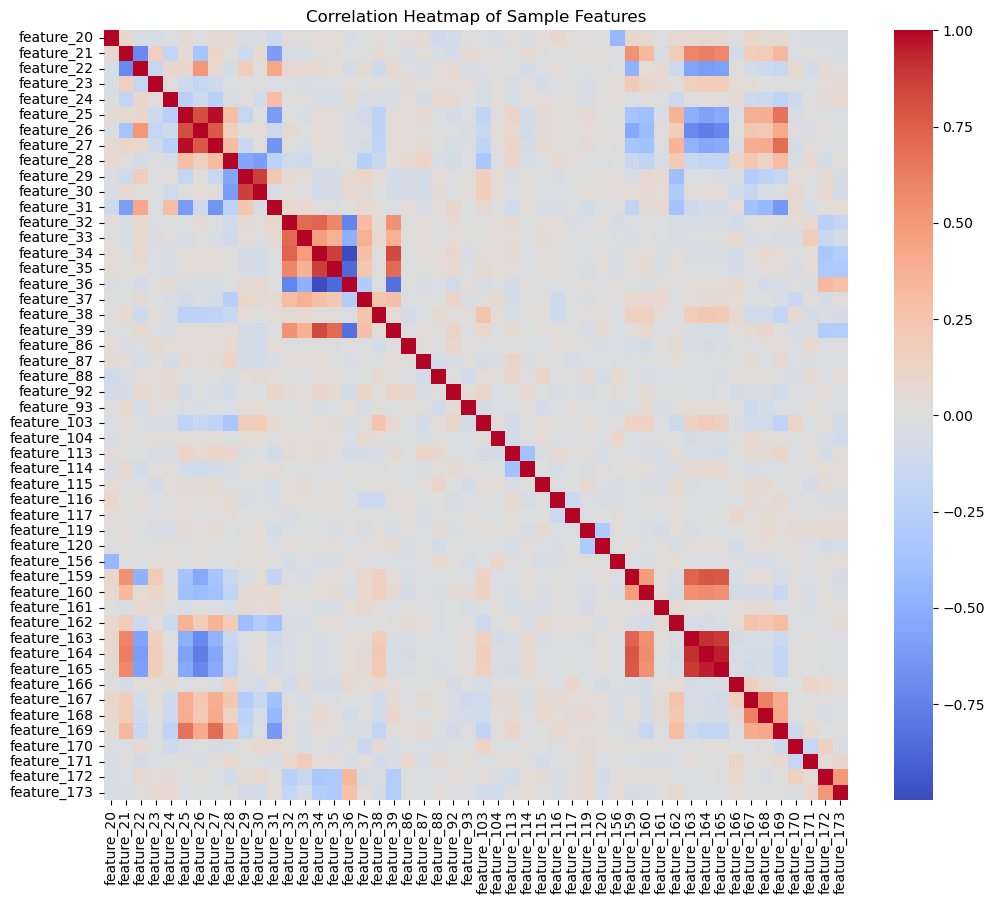

In [9]:
# 결측치 제거한 후 상위 50개 변수로 Heatmap
X_corr = X_train.dropna(axis=1)  # 결측치 있는 변수 제거
sample_corr = X_corr.iloc[:, :50].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(sample_corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap of Sample Features")
plt.show()


In [17]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. 50% 이상 결측치 제거
missing_ratio = X_train.isnull().mean()
valid_cols = missing_ratio[missing_ratio < 0.5].index
X_train_valid = X_train[valid_cols]

# 2. 결측치 대체 후보 방법 설정
imputers = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'knn': KNNImputer(n_neighbors=5)
}

# 3. 모델 정의
clf = DecisionTreeClassifier(random_state=42)

# 4. 각 Imputer 성능 평가 (5-Fold CV, f1_score)
from sklearn.metrics import make_scorer, f1_score

results = {}
for name, imputer in imputers.items():
    pipe = Pipeline([
        ('imputer', imputer),
        ('scaler', StandardScaler()),  # 스케일링은 이후 단계 고려
        ('clf', clf)
    ])
    scores = cross_val_score(pipe, X_train_valid, y_train, cv=5, scoring=make_scorer(f1_score, pos_label=1))
    results[name] = scores.mean()

# 결과 출력
print("결측치 처리 방법별 f1-score:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


📊 결측치 처리 방법별 f1-score:
mean: 0.1660
median: 0.1594
knn: 0.1093


In [18]:
# 선택된 Imputer로 전체 데이터 처리
final_imputer = SimpleImputer(strategy='mean')

# 1. Train 기준으로 fit
X_train_imputed = final_imputer.fit_transform(X_train[valid_cols])

# 2. Validation, Test는 transform만 수행
X_val_imputed = final_imputer.transform(X_val[valid_cols])
X_test_imputed = final_imputer.transform(X_test[valid_cols])


### 정규화 (Scaling)
- 변수의 크기 차이로 인한 모델 영향 제거
- 두 가지 방식 비교 후 더 좋은 쪽 선택
  - StandardScaler (z-score 정규화)
  - MinMaxScaler (0~1 정규화)
- 기준 모델: Decision Tree (결측치 처리 완료 상태)
- 평가: 5-Fold CV + F1-score


In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 기준 모델
clf = DecisionTreeClassifier(random_state=42)

# 사용 가능한 정제된 데이터셋 (결측치 평균 대체 완료)
X_scaled_base = X_train_imputed

# 스케일러 후보
scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler()
}

results_scaling = {}

for name, scaler in scalers.items():
    pipe = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])
    score = cross_val_score(pipe, X_scaled_base, y_train, cv=5, scoring=make_scorer(f1_score, pos_label=1)).mean()
    results_scaling[name] = score

# 결과 출력
print("정규화 방법별 f1-score:")
for k, v in results_scaling.items():
    print(f"{k}: {v:.4f}")


📊 정규화 방법별 f1-score:
standard: 0.1548
minmax: 0.1548


In [21]:
# 최종 선택된 스케일러
final_scaler = StandardScaler()

# Train에 대해 fit
X_train_scaled = final_scaler.fit_transform(X_train_imputed)

# Validation, Test는 transform만 수행
X_val_scaled = final_scaler.transform(X_val_imputed)
X_test_scaled = final_scaler.transform(X_test_imputed)


### Feature Selection (F-test 기반)
- 통계적 검정(F-test)을 통해 label(y)과 관련 있는 feature만 선택
- 기준: p-value < 0.05 (유의 수준 5%)
- 방법: SelectKBest (score_func = f_classif)
- Train에서 fit → Validation/Test에 동일 feature만 적용


In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

# 1. F-test 기반 Feature Selection
selector = SelectKBest(score_func=f_classif, k='all')  # 일단 전체 적용 후 p-value 확인
selector.fit(X_train_scaled, y_train)

# 2. 유의한 feature만 선택 (p < 0.05)
p_values = selector.pvalues_
selected_indices = np.where(p_values < 0.05)[0]
print(f"p < 0.05 조건을 만족하는 변수 개수: {len(selected_indices)}")

# 3. 선택된 feature만 다시 적용
X_train_selected = X_train_scaled[:, selected_indices]
X_val_selected = X_val_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]


📌 p < 0.05 조건을 만족하는 변수 개수: 71


C:\Users\SDS\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  5  13  42  49  52  69  96 137 145 172 173 180 183 184 185 186 187 188
 219 222 223 224 225 226 227 228 229 230 233 234 235 236 246 247 248 249
 250 251 252 253 254 255 256 266 274 301 302 303 310 313 314 315 316 317
 318 351 356 357 358 359 360 361 362 365 366 367 368 378 379 380 381 382
 383 384 385 386 387 388 398 406 433 434 435 442 445 446 447 448 449 450
 465 481 484 485 486 487 488 489 490 491 492 495 496 497 498 508 509 510
 511 512 513 514 515 516 517 518] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\SDS\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [24]:
selected_feature_names = np.array(valid_cols)[selected_indices]
print("선택된 주요 변수 이름 (상위 10개):")
print(selected_feature_names[:10])


📌 선택된 주요 변수 이름 (상위 10개):
['feature_14' 'feature_21' 'feature_22' 'feature_26' 'feature_28'
 'feature_59' 'feature_63' 'feature_64' 'feature_65' 'feature_67']


### 클래스 불균형 처리 (SMOTE)
- 불균형 클래스 문제를 해결하여 minority class (불량: 1)의 학습 향상
- 적용 범위: Train 데이터에만 적용


In [26]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# Train 데이터에만 적용
X_train_final, y_train_final = smote.fit_resample(X_train_selected, y_train)

# 클래스 비율 확인
from collections import Counter
print("SMOTE 적용 후 클래스 분포:", Counter(y_train_final))


✅ SMOTE 적용 후 클래스 분포: Counter({-1: 878, 1: 878})


### 기본 파라미터로 모델 성능 비교 (Validation 기준)
#### 비교 대상 모델
- 단일 모델: DecisionTree, LogisticRegression, KNN, NaiveBayes, SVM
- 앙상블 모델: RandomForest, AdaBoost, XGBoost

#### 평가 지표
- f1-score (불균형 데이터 대응)
- accuracy, precision, recall, confusion matrix도 함께 출력 가능


In [28]:
# y_train_final, y_val, y_test의 라벨을 0 (양품), 1 (불량)으로 통일
y_train_final_bin = (y_train_final == 1).astype(int)
y_val_bin = (y_val == 1).astype(int)
y_test_bin = (y_test == 1).astype(int)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# 모델 리스트
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 결과 저장용
model_scores = {}

# 각 모델 학습 및 평가
for name, model in models.items():
    model.fit(X_train_final, y_train_final_bin)  # 라벨 0,1로 변경
    y_pred = model.predict(X_val_selected)
    f1 = f1_score(y_val_bin, y_pred, pos_label=1)
    model_scores[name] = f1
    print(f"{name}: f1-score = {f1:.4f}")


✅ LogisticRegression: f1-score = 0.1748
✅ KNN: f1-score = 0.1702
✅ NaiveBayes: f1-score = 0.0526
✅ SVM: f1-score = 0.2456
✅ DecisionTree: f1-score = 0.1455
✅ RandomForest: f1-score = 0.0000


C:\Users\SDS\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ AdaBoost: f1-score = 0.1154
✅ XGBoost: f1-score = 0.1429


In [32]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 탐색할 파라미터 범위 설정
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']  # 먼저 rbf 커널만 실험
}

# 결과 저장용 리스트
results = []

# 모든 조합에 대해 학습 및 검증
for C, gamma, kernel in itertools.product(param_grid['C'], param_grid['gamma'], param_grid['kernel']):
    model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
    model.fit(X_train_final, y_train_final_bin)
    y_pred = model.predict(X_val_selected)
    f1 = f1_score(y_val_bin, y_pred)
    results.append({'C': C, 'gamma': gamma, 'kernel': kernel, 'f1': f1})

# 결과를 DataFrame으로 정리
df_results = pd.DataFrame(results)
best_row = df_results.loc[df_results['f1'].idxmax()]

print("✅ Best SVM Params:")
print(best_row)


✅ Best SVM Params:
C             10.0
gamma         0.01
kernel         rbf
f1        0.315789
Name: 13, dtype: object


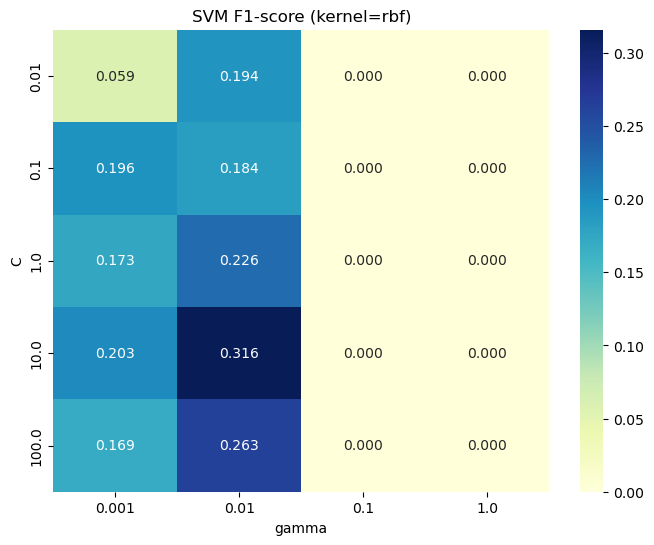

In [33]:
# heatmap으로 시각화
pivot_table = df_results.pivot(index='C', columns='gamma', values='f1')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("SVM F1-score (kernel=rbf)")
plt.xlabel("gamma")
plt.ylabel("C")
plt.show()


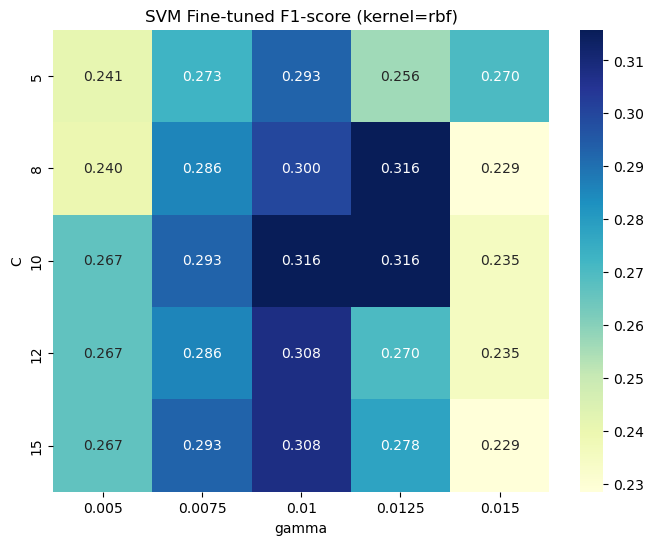

✅ Fine-tuned Best Params:
C                8
gamma       0.0125
kernel         rbf
f1        0.315789
Name: 8, dtype: object


In [34]:
# 세밀한 탐색 범위 설정
param_grid_fine = {
    'C': [5, 8, 10, 12, 15],
    'gamma': [0.005, 0.0075, 0.01, 0.0125, 0.015],
    'kernel': ['rbf']
}

# 결과 저장
results_fine = []

for C, gamma, kernel in itertools.product(param_grid_fine['C'], param_grid_fine['gamma'], param_grid_fine['kernel']):
    model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
    model.fit(X_train_final, y_train_final_bin)
    y_pred = model.predict(X_val_selected)
    f1 = f1_score(y_val_bin, y_pred)
    results_fine.append({'C': C, 'gamma': gamma, 'kernel': kernel, 'f1': f1})

# DataFrame 정리 및 시각화
df_results_fine = pd.DataFrame(results_fine)

pivot_fine = df_results_fine.pivot(index='C', columns='gamma', values='f1')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_fine, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("SVM Fine-tuned F1-score (kernel=rbf)")
plt.xlabel("gamma")
plt.ylabel("C")
plt.show()

# 최적 파라미터 출력
best_row_fine = df_results_fine.loc[df_results_fine['f1'].idxmax()]
print("Fine-tuned Best Params:")
print(best_row_fine)


In [36]:
# 최적 파라미터로 모델 재학습 (Train + Validation 합쳐서)
X_full = np.vstack([X_train_final, X_val_selected])
y_full = np.concatenate([y_train_final_bin, y_val_bin])

best_svm = SVC(C=10, gamma=0.01, kernel='rbf', random_state=42)
best_svm.fit(X_full, y_full)

# Test 데이터 예측 및 평가
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_test_pred = best_svm.predict(X_test_selected)

print("[SVM 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_test_pred, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_test_pred))


✅ [SVM 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.94      0.97      0.95       293
  Defect (1)       0.25      0.14      0.18        21

    accuracy                           0.91       314
   macro avg       0.60      0.56      0.57       314
weighted avg       0.89      0.91      0.90       314

Confusion Matrix:
 [[284   9]
 [ 18   3]]
ROC AUC Score: 0.5560702096538274


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import itertools

# 파라미터 후보 설정
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # l1/l2 모두 지원하며 소규모 데이터에 적합
}

results_logreg = []

# 모든 조합 학습 및 평가
for C, penalty, solver in itertools.product(param_grid['C'], param_grid['penalty'], param_grid['solver']):
    try:
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000, random_state=42)
        model.fit(X_train_final, y_train_final_bin)
        y_pred = model.predict(X_val_selected)
        f1 = f1_score(y_val_bin, y_pred)
        results_logreg.append({'C': C, 'penalty': penalty, 'solver': solver, 'f1': f1})
    except Exception as e:
        print(f"❌ Error at C={C}, penalty={penalty}: {e}")

# 결과 정리
df_logreg = pd.DataFrame(results_logreg)
best_logreg = df_logreg.loc[df_logreg['f1'].idxmax()]
print("Best Logistic Regression Params:")
print(best_logreg)


✅ Best Logistic Regression Params:
C               0.01
penalty           l1
solver     liblinear
f1          0.208955
Name: 0, dtype: object


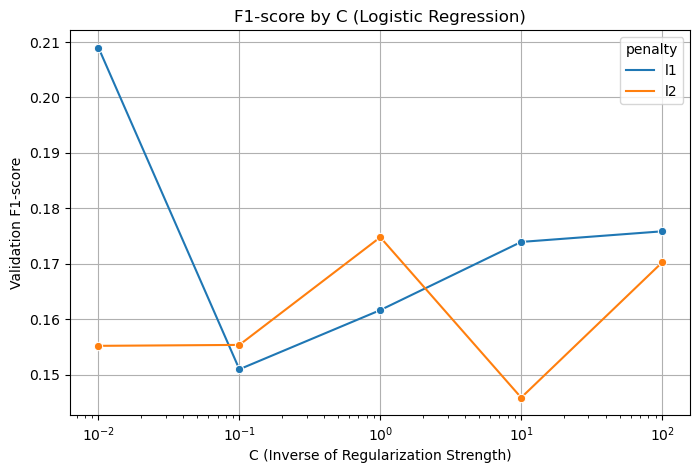

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_logreg, x='C', y='f1', hue='penalty', marker='o')
plt.title("F1-score by C (Logistic Regression)")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Validation F1-score")
plt.xscale('log')
plt.grid(True)
plt.show()


In [41]:
# Train + Validation 합쳐서 재학습
X_full = np.vstack([X_train_final, X_val_selected])
y_full = np.concatenate([y_train_final_bin, y_val_bin])

# 최적 파라미터로 Logistic Regression 학습
best_logreg = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
best_logreg.fit(X_full, y_full)

# Test 예측 및 평가
y_test_pred_logreg = best_logreg.predict(X_test_selected)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("[Logistic Regression 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_test_pred_logreg, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_logreg))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_test_pred_logreg))


✅ [Logistic Regression 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.96      0.82      0.89       293
  Defect (1)       0.17      0.52      0.26        21

    accuracy                           0.80       314
   macro avg       0.57      0.67      0.57       314
weighted avg       0.91      0.80      0.84       314

Confusion Matrix:
 [[241  52]
 [ 10  11]]
ROC AUC Score: 0.6731675605395742


In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import itertools
import warnings

warnings.filterwarnings("ignore")  # convergence warning 무시

# 파라미터 조합 정의
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu']
}

results_mlp = []

for hls, alpha, lr, activation in itertools.product(
    param_grid['hidden_layer_sizes'],
    param_grid['alpha'],
    param_grid['learning_rate_init'],
    param_grid['activation']
):
    model = MLPClassifier(hidden_layer_sizes=hls, alpha=alpha,
                          learning_rate_init=lr, activation=activation,
                          max_iter=500, random_state=42)
    model.fit(X_train_final, y_train_final_bin)
    y_pred = model.predict(X_val_selected)
    f1 = f1_score(y_val_bin, y_pred)
    results_mlp.append({
        'hidden_layer_sizes': hls,
        'alpha': alpha,
        'lr': lr,
        'activation': activation,
        'f1': f1
    })

# 결과 정리
df_mlp = pd.DataFrame(results_mlp)
best_mlp = df_mlp.loc[df_mlp['f1'].idxmax()]
print("Best MLP Parameters:")
print(best_mlp)


✅ Best MLP Parameters:
hidden_layer_sizes    (64, 32)
alpha                    0.001
lr                       0.001
activation                relu
f1                    0.243902
Name: 14, dtype: object


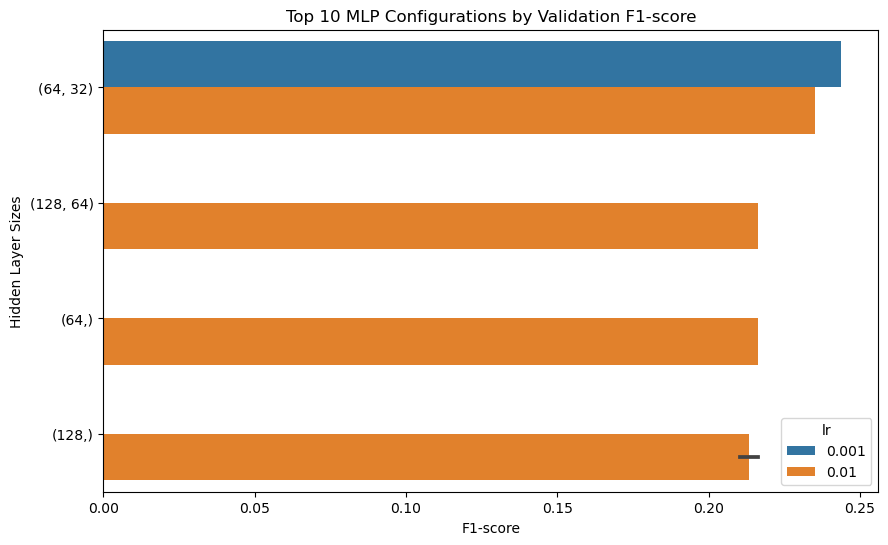

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=df_mlp.sort_values(by='f1', ascending=False).head(10),
            x='f1', y='hidden_layer_sizes', hue='lr')
plt.title("Top 10 MLP Configurations by Validation F1-score")
plt.xlabel("F1-score")
plt.ylabel("Hidden Layer Sizes")
plt.show()


In [46]:
# Train + Validation 합침
X_full = np.vstack([X_train_final, X_val_selected])
y_full = np.concatenate([y_train_final_bin, y_val_bin])

# 최적 MLP 모델로 학습
best_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), alpha=0.001,
                         learning_rate_init=0.001, activation='relu',
                         max_iter=500, random_state=42)

best_mlp.fit(X_full, y_full)

# Test 예측
y_test_pred_mlp = best_mlp.predict(X_test_selected)

# 평가
print("[MLPClassifier 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_test_pred_mlp, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_mlp))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_test_pred_mlp))


✅ [MLPClassifier 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.94      0.97      0.96       293
  Defect (1)       0.27      0.14      0.19        21

    accuracy                           0.92       314
   macro avg       0.61      0.56      0.57       314
weighted avg       0.90      0.92      0.90       314

Confusion Matrix:
 [[285   8]
 [ 18   3]]
ROC AUC Score: 0.5577766942954656


In [48]:
from sklearn.ensemble import VotingClassifier

# 각 개별 모델 정의 (최적 파라미터로)
svm_best = SVC(C=10, gamma=0.01, kernel='rbf', probability=False, random_state=42)
logreg_best = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
mlp_best = MLPClassifier(hidden_layer_sizes=(64, 32), alpha=0.001,
                         learning_rate_init=0.001, activation='relu',
                         max_iter=500, random_state=42)

# VotingClassifier 구성 (Hard Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_best),
        ('logreg', logreg_best),
        ('mlp', mlp_best)
    ],
    voting='hard'
)

# 전체 Train + Validation 데이터로 학습
voting_clf.fit(X_full, y_full)

# Test 데이터 예측 및 평가
y_test_pred_vote = voting_clf.predict(X_test_selected)

print("[Hard Voting Classifier 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_test_pred_vote, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_vote))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_test_pred_vote))


✅ [Hard Voting Classifier 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.94      0.96      0.95       293
  Defect (1)       0.21      0.14      0.17        21

    accuracy                           0.91       314
   macro avg       0.58      0.55      0.56       314
weighted avg       0.89      0.91      0.90       314

Confusion Matrix:
 [[282  11]
 [ 18   3]]
ROC AUC Score: 0.5526572403705509


In [50]:
from sklearn.ensemble import VotingClassifier

# SVC는 확률 예측 가능하게 설정
svm_best_prob = SVC(C=10, gamma=0.01, kernel='rbf', probability=True, random_state=42)
logreg_best = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
mlp_best = MLPClassifier(hidden_layer_sizes=(64, 32), alpha=0.001,
                         learning_rate_init=0.001, activation='relu',
                         max_iter=500, random_state=42)

# Soft VotingClassifier
voting_soft = VotingClassifier(
    estimators=[
        ('svm', svm_best_prob),
        ('logreg', logreg_best),
        ('mlp', mlp_best)
    ],
    voting='soft'
)

# Train + Validation으로 학습
voting_soft.fit(X_full, y_full)

# Test 예측
y_test_pred_soft = voting_soft.predict(X_test_selected)

# 평가
print("[Soft Voting Classifier 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_test_pred_soft, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_soft))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_test_pred_soft))


✅ [Soft Voting Classifier 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.94      0.98      0.96       293
  Defect (1)       0.30      0.14      0.19        21

    accuracy                           0.92       314
   macro avg       0.62      0.56      0.58       314
weighted avg       0.90      0.92      0.91       314

Confusion Matrix:
 [[286   7]
 [ 18   3]]
ROC AUC Score: 0.5594831789371039


In [52]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# 최적화된 Base 모델
svm_stack = SVC(C=10, gamma=0.01, kernel='rbf', probability=True, random_state=42)
logreg_stack = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
mlp_stack = MLPClassifier(hidden_layer_sizes=(64, 32), alpha=0.001,
                          learning_rate_init=0.001, activation='relu',
                          max_iter=500, random_state=42)

# Meta-learner: Logistic Regression
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# StackingClassifier 구성
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', svm_stack),
        ('logreg', logreg_stack),
        ('mlp', mlp_stack)
    ],
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba',  # soft stacking
    passthrough=False,             # meta learner는 base feature는 안 씀
    n_jobs=-1
)

# 전체 학습 (Train + Validation)
stacking_clf.fit(X_full, y_full)

# Test 예측 및 평가
y_test_pred_stack = stacking_clf.predict(X_test_selected)

print("[Stacking Classifier 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_test_pred_stack, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_stack))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_test_pred_stack))


✅ [Stacking Classifier 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.94      0.99      0.97       293
  Defect (1)       0.50      0.14      0.22        21

    accuracy                           0.93       314
   macro avg       0.72      0.57      0.59       314
weighted avg       0.91      0.93      0.92       314

Confusion Matrix:
 [[290   3]
 [ 18   3]]
ROC AUC Score: 0.5663091175036566


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import itertools

# 튜닝할 파라미터 조합
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']  # 불균형 보정
}

# 결과 저장용 리스트
results_rf = []

for n, depth, split, feat, weight in itertools.product(
    param_grid_rf['n_estimators'],
    param_grid_rf['max_depth'],
    param_grid_rf['min_samples_split'],
    param_grid_rf['max_features'],
    param_grid_rf['class_weight']
):
    model = RandomForestClassifier(
        n_estimators=n,
        max_depth=depth,
        min_samples_split=split,
        max_features=feat,
        class_weight=weight,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_final, y_train_final_bin)
    y_pred = model.predict(X_val_selected)
    f1 = f1_score(y_val_bin, y_pred)
    results_rf.append({
        'n_estimators': n,
        'max_depth': depth,
        'min_samples_split': split,
        'max_features': feat,
        'class_weight': weight,
        'f1': f1
    })

# 결과 정리
import pandas as pd
df_rf = pd.DataFrame(results_rf)
best_rf = df_rf.loc[df_rf['f1'].idxmax()]
print("Best Random Forest Parameters:")
print(best_rf)


✅ Best Random Forest Parameters:
n_estimators              200
max_depth                   5
min_samples_split           2
max_features             sqrt
class_weight         balanced
f1                   0.291667
Name: 24, dtype: object


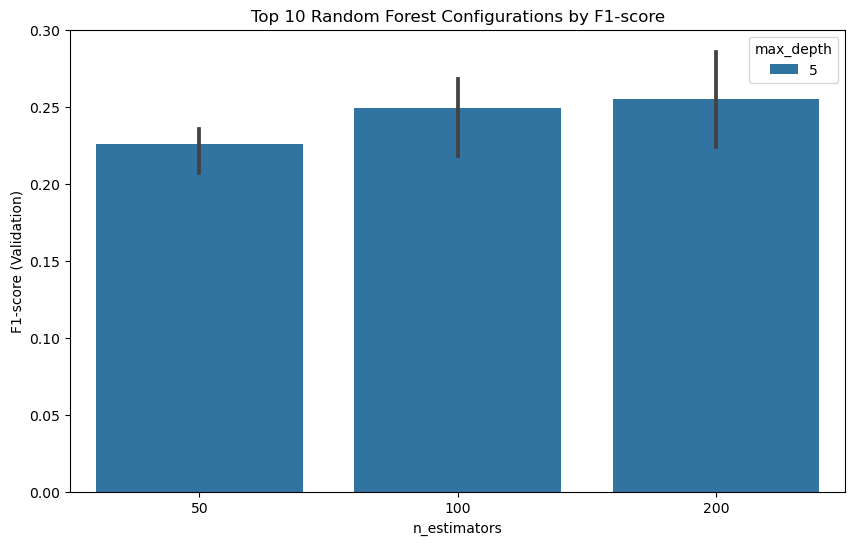

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

top_rf = df_rf.sort_values(by='f1', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_rf, y='f1', x='n_estimators', hue='max_depth')
plt.title("Top 10 Random Forest Configurations by F1-score")
plt.ylabel("F1-score (Validation)")
plt.xlabel("n_estimators")
plt.show()


In [57]:
# 최적 파라미터로 모델 학습 및 테스트
best_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
best_rf_model.fit(X_full, y_full)
y_pred_test_rf = best_rf_model.predict(X_test_selected)

# 평가 지표
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("[Random Forest 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_pred_test_rf, target_names=['Good (0)', 'Defect (1)']))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_test_rf))
print("ROC AUC Score:", roc_auc_score(y_test_bin, best_rf_model.predict_proba(X_test_selected)[:, 1]))


✅ [Random Forest 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.95      0.92      0.93       293
  Defect (1)       0.21      0.29      0.24        21

    accuracy                           0.88       314
   macro avg       0.58      0.60      0.59       314
weighted avg       0.90      0.88      0.89       314

Confusion Matrix:
 [[270  23]
 [ 15   6]]
ROC AUC Score: 0.7476027953843654


In [63]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 하이퍼파라미터 후보
n_estimators_list = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1, 1.0]
max_depths = [1, 2, 3]

results = []

# 튜닝 루프
for depth in max_depths:
    base = DecisionTreeClassifier(max_depth=depth, random_state=42)
    for lr in learning_rates:
        for n in n_estimators_list:
            model = AdaBoostClassifier(
                estimator=base,
                n_estimators=n,
                learning_rate=lr,
                random_state=42
            )
            model.fit(X_train_final, y_train_final_bin)
            preds = model.predict(X_val_selected)
            f1 = f1_score(y_val_bin, preds)
            results.append({
                'max_depth': depth,
                'learning_rate': lr,
                'n_estimators': n,
                'f1': f1
            })

# 결과 DataFrame 정리
ada_results = pd.DataFrame(results)
best_ada = ada_results.sort_values(by='f1', ascending=False).iloc[0]
print("Best AdaBoost Parameters:")
print(best_ada)


✅ Best AdaBoost Parameters:
max_depth          2.000000
learning_rate      0.010000
n_estimators     200.000000
f1                 0.204082
Name: 17, dtype: float64


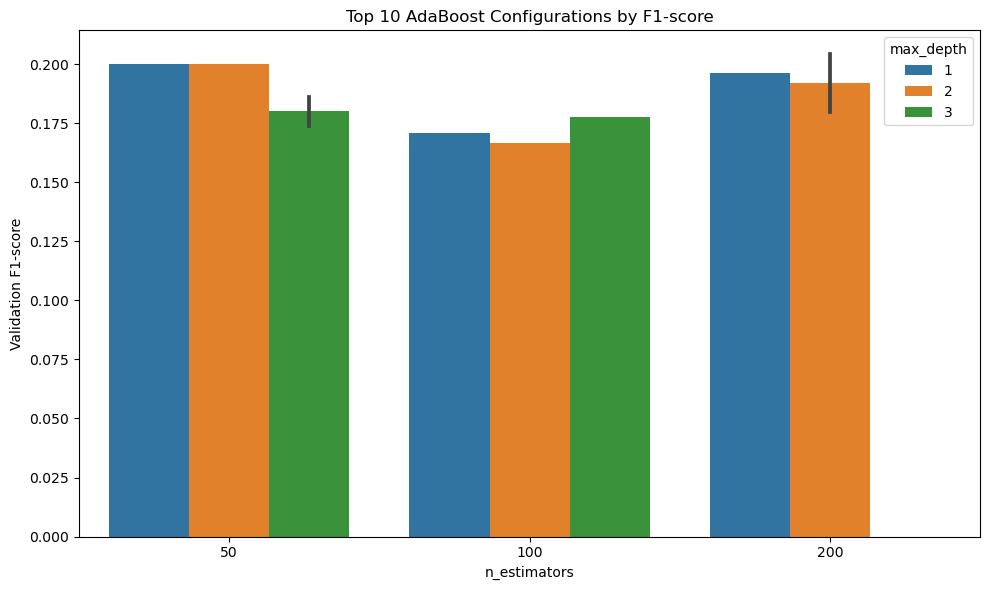

In [64]:
import seaborn as sns

# 상위 10개 조합 시각화
top10 = ada_results.sort_values(by='f1', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x='n_estimators', y='f1', hue='max_depth')
plt.title("Top 10 AdaBoost Configurations by F1-score")
plt.ylabel("Validation F1-score")
plt.xlabel("n_estimators")
plt.legend(title='max_depth')
plt.tight_layout()
plt.show()


In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# 최적 파라미터 기반 모델 정의
best_ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=42),
    n_estimators=200,
    learning_rate=0.01,
    random_state=42
)

# Train+Val 전체 데이터(X_full, y_full)로 재학습
best_ada_model.fit(X_full, y_full)

# Test 데이터에 대한 예측
y_test_pred_ada = best_ada_model.predict(X_test_selected)

# 평가 지표 출력
print("[AdaBoost 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_test_pred_ada, target_names=['Good (0)', 'Defect (1)']))

print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_test_pred_ada))

# ROC AUC는 predict_proba 사용
y_proba_ada = best_ada_model.predict_proba(X_test_selected)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_ada))


✅ [AdaBoost 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.94      0.92      0.93       293
  Defect (1)       0.18      0.24      0.20        21

    accuracy                           0.88       314
   macro avg       0.56      0.58      0.57       314
weighted avg       0.89      0.88      0.88       314

Confusion Matrix:
[[270  23]
 [ 16   5]]
ROC AUC Score: 0.6705672029904112


In [69]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import pandas as pd

# 파라미터 그리드
n_estimators_list = [10, 50, 100]
max_samples_list = [0.5, 0.7, 1.0]

results_bagging = []

# 튜닝 루프
for n in n_estimators_list:
    for s in max_samples_list:
        model = BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
            n_estimators=n,
            max_samples=s,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_final, y_train_final_bin)
        y_pred = model.predict(X_val_selected)
        f1 = f1_score(y_val_bin, y_pred)
        results_bagging.append({
            'n_estimators': n,
            'max_samples': s,
            'f1': f1
        })

# 결과 정리
df_bagging = pd.DataFrame(results_bagging)
best_bagging = df_bagging.sort_values(by='f1', ascending=False).iloc[0]
print("Best Bagging Parameters:")
print(best_bagging)


✅ Best Bagging Parameters:
n_estimators    100.000000
max_samples       1.000000
f1                0.217391
Name: 8, dtype: float64


In [70]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 최적 파라미터로 전체 학습
best_bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=100,
    max_samples=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Train+Val 데이터로 학습
best_bagging_model.fit(X_full, y_full)

# Test 예측
y_pred_bag = best_bagging_model.predict(X_test_selected)
y_prob_bag = best_bagging_model.predict_proba(X_test_selected)[:, 1]

# 평가 출력
print("[Bagging Classifier 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_pred_bag, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_pred_bag))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_prob_bag))


✅ [Bagging Classifier 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.95      0.95      0.95       293
  Defect (1)       0.29      0.29      0.29        21

    accuracy                           0.90       314
   macro avg       0.62      0.62      0.62       314
weighted avg       0.90      0.90      0.90       314

Confusion Matrix:
[[278  15]
 [ 15   6]]
ROC AUC Score: 0.7568665691532586


In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import pandas as pd

# 튜닝을 위한 파라미터 후보
n_estimators_list = [50, 100, 200]
max_depth_list = [3, 5, 7]
learning_rate_list = [0.01, 0.05, 0.1]
subsample_list = [0.8, 1.0]
colsample_bytree_list = [0.8, 1.0]

results = []

for n in n_estimators_list:
    for d in max_depth_list:
        for lr in learning_rate_list:
            for sub in subsample_list:
                for col in colsample_bytree_list:
                    model = XGBClassifier(
                        n_estimators=n,
                        max_depth=d,
                        learning_rate=lr,
                        subsample=sub,
                        colsample_bytree=col,
                        use_label_encoder=False,
                        eval_metric='logloss',
                        random_state=42
                    )
                    model.fit(X_train_final, y_train_final_bin)
                    preds = model.predict(X_val_selected)
                    f1 = f1_score(y_val_bin, preds, pos_label=1)
                    results.append({
                        'n_estimators': n,
                        'max_depth': d,
                        'learning_rate': lr,
                        'subsample': sub,
                        'colsample_bytree': col,
                        'f1': f1
                    })

# 결과 정리
xgb_results = pd.DataFrame(results)
xgb_results = xgb_results.sort_values(by='f1', ascending=False).reset_index(drop=True)

# 상위 5개 결과 출력
print(xgb_results.head())


   n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
0           100          3           0.10        0.8               0.8   
1            50          3           0.05        0.8               0.8   
2            50          5           0.10        0.8               0.8   
3            50          3           0.01        1.0               0.8   
4           100          3           0.05        0.8               0.8   

         f1  
0  0.235294  
1  0.208333  
2  0.181818  
3  0.181818  
4  0.181818  


In [74]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 최종 모델 학습
final_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.10,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train + Validation으로 재학습
final_xgb.fit(X_full, y_full)

# Test 데이터 예측
y_pred = final_xgb.predict(X_test_selected)

# 결과 출력
print("[XGBoost 최종 Test 성능 평가]")
print(classification_report(y_test_bin, y_pred, target_names=["Good (0)", "Defect (1)"]))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_pred))


✅ [XGBoost 최종 Test 성능 평가]
              precision    recall  f1-score   support

    Good (0)       0.94      0.96      0.95       293
  Defect (1)       0.21      0.14      0.17        21

    accuracy                           0.91       314
   macro avg       0.58      0.55      0.56       314
weighted avg       0.89      0.91      0.90       314

Confusion Matrix:
 [[282  11]
 [ 18   3]]
ROC AUC Score: 0.5526572403705509


### 변수별 중요도 분석

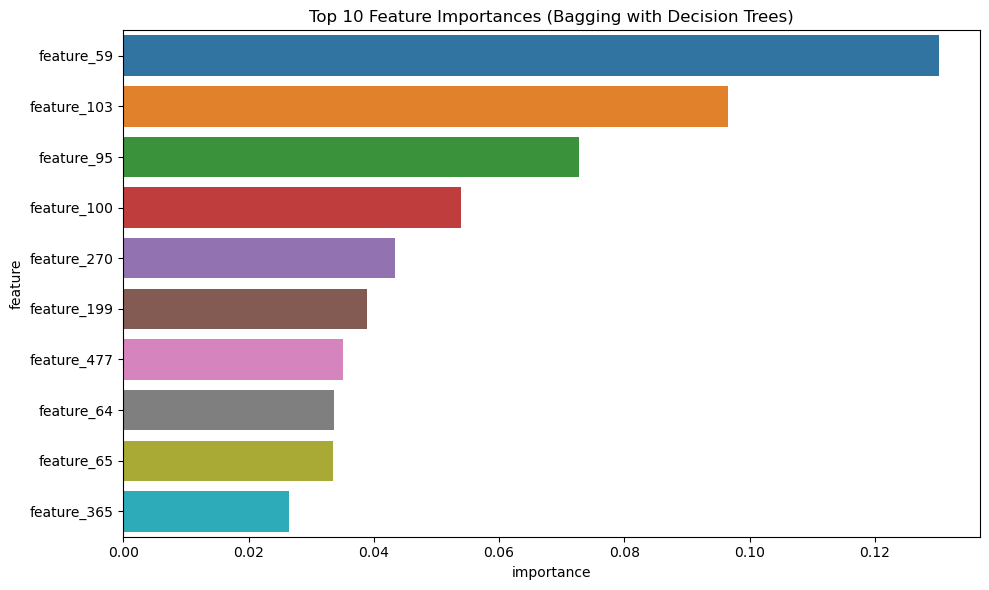

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
selected_feature_names

# 이미 학습된 bagging_model 가정
# 예: BaggingClassifier(base_estimator=DecisionTreeClassifier(...))

# 각 트리의 feature importance 추출 후 평균 계산

importances = np.mean([tree.feature_importances_ for tree in best_bagging_model.estimators_], axis=0)

# 정렬 및 시각화
importance_df = pd.DataFrame({'feature': selected_feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(10)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title("Top 10 Feature Importances (Bagging with Decision Trees)")
plt.tight_layout()
plt.show()


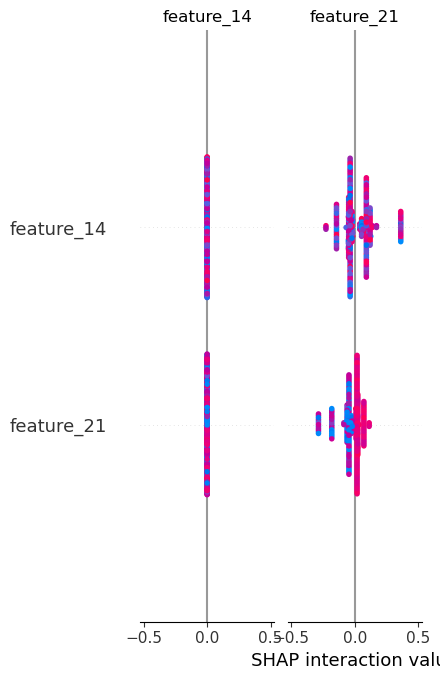

In [89]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 첫 번째 의사결정나무 모델 추출
tree_model = best_bagging_model.estimators_[0]

# 2. 테스트 데이터를 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)

# 3. SHAP explainer 생성 및 shap값 계산
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test_df)

# 4. shap_values 타입 확인 후 분기
if isinstance(shap_values, list) and len(shap_values) == 2:
    # 클래스별 SHAP (e.g. shap_values[1]은 클래스 1)
    shap.summary_plot(shap_values[1], X_test_df, feature_names=selected_feature_names)
else:
    # 일반적인 SHAP (e.g. 다중분류 X or 단일 반환값)
    shap.summary_plot(shap_values, X_test_df, feature_names=selected_feature_names)
